In [1]:
import os, os.path
import pickle
import time
import numpy
from scipy import interpolate
from galpy.util import bovy_conversion, bovy_plot, save_pickles
import gd1_util
from gd1_util import R0, V0
import seaborn as sns
from matplotlib import cm, pyplot
import simulate_streampepper
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
%pylab inline
from matplotlib.ticker import NullFormatter, FuncFormatter
save_figures= False

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# Figures for the section on approximately computing the stream structure

In [2]:
# Load the smooth and peppered stream
sdf_smooth= gd1_util.setup_gd1model()
pepperfilename= 'gd1pepper.pkl'
if os.path.exists(pepperfilename):
    with open(pepperfilename,'rb') as savefile:
        sdf_pepper= pickle.load(savefile)
else:
    timpacts= simulate_streampepper.parse_times('256sampling')
    sdf_pepper= gd1_util.setup_gd1model(timpact=timpacts,
                                        hernquist=True)
    save_pickles(pepperfilename,sdf_pepper)

## Is the mean perpendicular frequency close to zero?

In [3]:
# Sampling functions
massrange=[5.,9.]
plummer= False
Xrs= 5.
nsubhalo= simulate_streampepper.nsubhalo
rs= simulate_streampepper.rs
dNencdm= simulate_streampepper.dNencdm
sample_GM= lambda: (10.**((-0.5)*massrange[0])\
                                    +(10.**((-0.5)*massrange[1])\
                                          -10.**((-0.5)*massrange[0]))\
                                    *numpy.random.uniform())**(1./(-0.5))\
                                    /bovy_conversion.mass_in_msol(V0,R0)
rate_range= numpy.arange(massrange[0]+0.5,massrange[1]+0.5,1)
rate= numpy.sum([dNencdm(sdf_pepper,10.**r,Xrs=Xrs,
                                plummer=plummer)
                        for r in rate_range])
sample_rs= lambda x: rs(x*bovy_conversion.mass_in_1010msol(V0,R0)*10.**10.,
                            plummer=plummer)

In [4]:
numpy.random.seed(2)
sdf_pepper.simulate(rate=rate,sample_GM=sample_GM,sample_rs=sample_rs,Xrs=Xrs)

In [5]:
n= 100000
aa_mock_per= sdf_pepper.sample(n=n,returnaAdt=True)
dO= numpy.dot(aa_mock_per[0].T-sdf_pepper._progenitor_Omega,
              sdf_pepper._sigomatrixEig[1][:,sdf_pepper._sigomatrixEigsortIndx])
dO[:,2]*= sdf_pepper._sigMeanSign
da= numpy.dot(aa_mock_per[1].T-sdf_pepper._progenitor_angle,
              sdf_pepper._sigomatrixEig[1][:,sdf_pepper._sigomatrixEigsortIndx])
da[:,2]*= sdf_pepper._sigMeanSign
apar= da[:,2]
xs= numpy.linspace(0.,1.5,1001)
mO_unp= numpy.array([sdf_smooth.meanOmega(x,oned=True) for x in xs])
mOint= interpolate.InterpolatedUnivariateSpline(xs,mO_unp,k=3)

In [15]:
mOs= mOint(apar)
frac= 0.02
alpha=0.01
linecolor='0.65'
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,4)
subplot(1,3,1)
bovy_plot.bovy_plot(apar[::3],dO[::3,2]/mOs[::3]-1,'k.',alpha=alpha*2,gcf=True,
                   rasterized=True)
z= lowess(dO[:,2]/mOs-1,apar,frac=frac)
plot(z[::100,0],z[::100,1],color=linecolor,lw=2.5)
xlim(0.,1.5)
ylim(-1.2,1.2)
xlabel(r'$\Delta\theta_\parallel$')
bovy_plot.bovy_text(r'$\Delta\Omega_\parallel/\langle\Delta\Omega^0_\parallel\rangle-1$',top_left=True,
                   size=18.)
subplot(1,3,2)
bovy_plot.bovy_plot(apar[::3],dO[::3,1]/mOs[::3],'k.',alpha=alpha*2,gcf=True,
                   rasterized=True)
z= lowess(dO[:,1]/mOs,apar,frac=frac)
plot(z[::100,0],z[::100,1],color=linecolor,lw=2.5)
xlim(0.,1.5)
ylim(-0.05,0.05)
xlabel(r'$\Delta\theta_\parallel$')
bovy_plot.bovy_text(r'$\Delta\Omega_{\perp,1}/\langle\Delta\Omega^0_\parallel\rangle$',top_left=True,
                   size=18.)
subplot(1,3,3)
bovy_plot.bovy_plot(apar[::3],dO[::3,0]/mOs[::3],'k.',alpha=alpha,gcf=True,
                   rasterized=True)
z= lowess(dO[:,0]/mOs,apar,frac=frac)
plot(z[::100,0],z[::100,1],color=linecolor,lw=2.5)
xlim(0.,1.5)
ylim(-0.05,0.05)
xlabel(r'$\Delta\theta_\parallel$')
bovy_plot.bovy_text(r'$\Delta\Omega_{\perp,2}/\langle\Delta\Omega^0_\parallel\rangle$',top_left=True,
                   size=18.)
if save_figures:
    tight_layout()
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_meanOparOperp.pdf'))

In [17]:
print "This stream had %i impacts" % len(sdf_pepper._GM)

This stream had 61 impacts


## Test the single-impact approximations

In [71]:
# Setup a single, large impact
m= 10.**8.
GM= 10**8./bovy_conversion.mass_in_msol(V0,R0)
timpactIndx= numpy.argmin(numpy.fabs(numpy.array(sdf_pepper._uniq_timpact)-1.3/bovy_conversion.time_in_Gyr(V0,R0)))
# Load the single-impact stream
gapfilename= 'gd1single.pkl'
if os.path.exists(gapfilename):
    with open(gapfilename,'rb') as savefile:
        sdf_gap= pickle.load(savefile)
else:
    sdf_gap= gd1_util.setup_gd1model(hernquist=True,
                                     singleImpact=True,
                                     impactb=0.5*rs(m),
                                     subhalovel=numpy.array([-25.,155.,30.])/V0,
                                     impact_angle=0.6,
                                     timpact=sdf_pepper._uniq_timpact[timpactIndx],
                                     GM=GM,rs=rs(m))
    save_pickles(gapfilename,sdf_gap)

In [5]:
n= 100000
aa_mock_per= sdf_gap.sample(n=n,returnaAdt=True)
dO= numpy.dot(aa_mock_per[0].T-sdf_gap._progenitor_Omega,
              sdf_gap._sigomatrixEig[1][:,sdf_gap._sigomatrixEigsortIndx])
dO[:,2]*= sdf_gap._sigMeanSign
da= numpy.dot(aa_mock_per[1].T-sdf_gap._progenitor_angle,
              sdf_gap._sigomatrixEig[1][:,sdf_gap._sigomatrixEigsortIndx])
da[:,2]*= sdf_gap._sigMeanSign

In [6]:
num= True
apar= numpy.arange(0.,sdf_smooth.length()+0.003,0.003)
dens_unp= numpy.array([sdf_smooth._density_par(x) for x in apar])
dens_approx= numpy.array([sdf_gap.density_par(x,approx=True) for x in apar])
dens_approx_higherorder= numpy.array([sdf_gap._density_par(x,approx=True,higherorder=True) for x in apar])
# normalize
dens_unp= dens_unp/numpy.sum(dens_unp)/(apar[1]-apar[0])
dens_approx= dens_approx/numpy.sum(dens_approx)/(apar[1]-apar[0])
dens_approx_higherorder= dens_approx_higherorder/numpy.sum(dens_approx_higherorder)/(apar[1]-apar[0])
if num:
    dens_num= numpy.array([sdf_gap.density_par(x,approx=False) for x in apar])
    dens_num= dens_num/numpy.sum(dens_num)/(apar[1]-apar[0])

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)



In [12]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(6,7)
axTop= pyplot.axes([0.15,0.3,0.825,0.65])
fig= pyplot.gcf()
fig.sca(axTop)
bovy_plot.bovy_plot(apar,dens_approx,lw=2.5,gcf=True,
                    color='k',
                   xrange=[0.,1.],
                   yrange=[0.,2.24],
                   ylabel=r'$\mathrm{density}$')
plot(apar,dens_unp,lw=3.5,color='k',ls='--',zorder=0)
nullfmt   = NullFormatter()         # no labels
axTop.xaxis.set_major_formatter(nullfmt)
dum= hist(da[:,2],bins=101,normed=True,range=[apar[0],apar[-1]],
          histtype='step',color='0.55',zorder=0,lw=3.)
axBottom= pyplot.axes([0.15,0.1,0.825,0.2])
fig= pyplot.gcf()
fig.sca(axBottom)
bovy_plot.bovy_plot(apar,100.*(dens_approx_higherorder-dens_approx)/dens_approx_higherorder,
                    lw=2.5,gcf=True,color='k',
                    xrange=[0.,1.],
                    yrange=[-0.145,0.145],
                    zorder=2,
                    xlabel=r'$\Delta \theta_\parallel$',
                    ylabel=r'$\mathrm{relative\ difference\ in}\ \%$')
if num:
    plot(apar,100.*(dens_num-dens_approx_higherorder)/dens_approx_higherorder,
         lw=2.5,zorder=1,color='0.55')
# label
aparIndx= numpy.argmin(numpy.fabs(apar-0.64))
plot([0.45,apar[aparIndx]],[0.06,(100.*(dens_approx_higherorder-dens_approx)/dens_approx_higherorder)[aparIndx]],
    'k',lw=1.)
bovy_plot.bovy_text(0.1,0.07,r'$\mathrm{higher\!\!-\!\!order\ minus\ linear}$',size=17.)
if num:
    aparIndx= numpy.argmin(numpy.fabs(apar-0.62))
    plot([0.45,apar[aparIndx]],[-0.07,(100.*(dens_num-dens_approx_higherorder)/dens_approx_higherorder)[aparIndx]],
        'k',lw=1.)
    bovy_plot.bovy_text(0.05,-0.12,r'$\mathrm{numerical\ minus\ higher\!\!-\!\!order}$',size=17.)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1likeSingle_densapprox.pdf'))

In [8]:
mO_unp= numpy.array([sdf_smooth.meanOmega(x,oned=True) for x in apar])\
    *bovy_conversion.freq_in_Gyr(V0,R0)
mO_approx= numpy.array([sdf_gap.meanOmega(x,approx=True,oned=True) for x in apar])\
    *bovy_conversion.freq_in_Gyr(V0,R0)
mO_approx_higherorder= numpy.array([sdf_gap.meanOmega(x,oned=True,approx=True,higherorder=True) for x in apar])\
    *bovy_conversion.freq_in_Gyr(V0,R0)
if num:
    mO_num= numpy.array([sdf_gap.meanOmega(x,approx=False,oned=True) for x in apar])\
       *bovy_conversion.freq_in_Gyr(V0,R0)

In [13]:
frac= 0.005
alpha=0.01
linecolor='0.65'
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(6,7)
axTop= pyplot.axes([0.15,0.3,0.825,0.65])
fig= pyplot.gcf()
fig.sca(axTop)
bovy_plot.bovy_plot(apar,mO_approx,lw=2.5,gcf=True,
                    color='k',
                   xrange=[0.,1.],
                   yrange=[0.,0.2],
                   ylabel=r'$\Delta \Omega_\parallel\,(\mathrm{Gyr}^{-1})$')
plot(apar,mO_unp,lw=2.5,color='k',ls='--')
plot(da[::3,2],dO[::3,2]*bovy_conversion.freq_in_Gyr(V0,R0),
     'k.',alpha=alpha*2,rasterized=True)
nullfmt   = NullFormatter()         # no labels
axTop.xaxis.set_major_formatter(nullfmt)
axBottom= pyplot.axes([0.15,0.1,0.825,0.2])
fig= pyplot.gcf()
fig.sca(axBottom)
bovy_plot.bovy_plot(apar,100.*(mO_approx_higherorder-mO_approx)/mO_approx_higherorder,
                    lw=2.5,gcf=True,color='k',
                    xrange=[0.,1.],zorder=1,
                    yrange=[-0.039,0.039],
                    xlabel=r'$\Delta \theta_\parallel$',
                    ylabel=r'$\mathrm{relative\ difference\ in\ \%}$')
if num:
    plot(apar,100.*(mO_num-mO_approx_higherorder)/mO_approx_higherorder,
         lw=2.5,color='0.55',zorder=0)
# label
aparIndx= numpy.argmin(numpy.fabs(apar-0.64))
plot([0.45,apar[aparIndx]],[0.024,(100.*(mO_approx_higherorder-mO_approx)/mO_approx_higherorder)[aparIndx]],
    'k',lw=1.)
bovy_plot.bovy_text(0.1,0.026,r'$\mathrm{higher\!\!-\!\!order\ minus\ linear}$',size=17.)
aparIndx= numpy.argmin(numpy.fabs(apar-0.6))
if num:
    plot([0.45,apar[aparIndx]],[-0.02,(100.*(mO_num-mO_approx_higherorder)/mO_approx_higherorder)[aparIndx]],
        'k',lw=1.)
    bovy_plot.bovy_text(0.05,-0.03,r'$\mathrm{numerical\ minus\ higher\!\!-\!\!order}$',size=17.)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1likeSingle_mOparapprox.pdf'))

In [74]:
start= time.time()
numpy.array([sdf_gap.density_par(x,approx=False) for x in apar[::10]])
end= time.time()
print (end-start)*1000.*10./len(apar)
start= time.time()
numpy.array([sdf_gap.density_par(x,approx=True) for x in apar[::10]])
end= time.time()
print (end-start)*1000.*10./len(apar)
start= time.time()
numpy.array([sdf_gap.density_par(x,approx=True,higherorder=True) for x in apar[::10]])
end= time.time()
print (end-start)*1000.*10./len(apar)

115.793423219
0.0852093552098
0.672427090732


In [75]:
start= time.time()
numpy.array([sdf_gap.meanOmega(x,approx=False,oned=True) for x in apar[::10]])
end= time.time()
print (end-start)*1000.*10./len(apar)
start= time.time()
numpy.array([sdf_gap.meanOmega(x,approx=True,oned=True) for x in apar[::10]])
end= time.time()
print (end-start)*1000.*10./len(apar)
start= time.time()
numpy.array([sdf_gap.meanOmega(x,approx=True,oned=True,higherorder=True) for x in apar[::10]])
end= time.time()
print (end-start)*1000.*10./len(apar)

178.332213199
0.24033315254
2.04815286579


## Test the multiple-impact approximations

In [21]:
# Setup a four, intermediate impacts
m= [10.**7.,10.**7.25,10.**6.75,10.**7.5]
GM= [mm/bovy_conversion.mass_in_msol(V0,R0) for mm in m]
timpactIndx= [numpy.argmin(numpy.fabs(numpy.array(sdf_pepper._uniq_timpact)-1.3/bovy_conversion.time_in_Gyr(V0,R0))),
              numpy.argmin(numpy.fabs(numpy.array(sdf_pepper._uniq_timpact)-2.3/bovy_conversion.time_in_Gyr(V0,R0))),
              numpy.argmin(numpy.fabs(numpy.array(sdf_pepper._uniq_timpact)-3.3/bovy_conversion.time_in_Gyr(V0,R0))),
              numpy.argmin(numpy.fabs(numpy.array(sdf_pepper._uniq_timpact)-4.3/bovy_conversion.time_in_Gyr(V0,R0)))]
sdf_pepper.set_impacts(impactb=[0.5*rs(m[0]),2.*rs(m[1]),1.*rs(m[2]),2.5*rs(m[3])],
                       subhalovel=numpy.array([[-25.,155.,30.],
                                               [125.,35.,80.],
                                               [-225.,5.,-40.],
                                               [25.,-155.,37.]])/V0,
                       impact_angle=[0.6,0.4,0.3,0.3],
                       timpact=[sdf_pepper._uniq_timpact[ti] for ti in timpactIndx],
                       GM=GM,rs=[rs(mm) for mm in m])
sdf_gap= sdf_pepper

In [22]:
n= 100000
aa_mock_per= sdf_pepper.sample(n=n,returnaAdt=True)
dO= numpy.dot(aa_mock_per[0].T-sdf_gap._progenitor_Omega,
              sdf_gap._sigomatrixEig[1][:,sdf_gap._sigomatrixEigsortIndx])
dO[:,2]*= sdf_gap._sigMeanSign
da= numpy.dot(aa_mock_per[1].T-sdf_gap._progenitor_angle,
              sdf_gap._sigomatrixEig[1][:,sdf_gap._sigomatrixEigsortIndx])
da[:,2]*= sdf_gap._sigMeanSign

In [29]:
num= True
apar= numpy.arange(0.,sdf_smooth.length()+0.003,0.003)
dens_unp= numpy.array([sdf_smooth._density_par(x) for x in apar])
dens_approx= numpy.array([sdf_gap.density_par(x,approx=True) for x in apar])
# normalize
dens_unp= dens_unp/numpy.sum(dens_unp)/(apar[1]-apar[0])
dens_approx= dens_approx/numpy.sum(dens_approx)/(apar[1]-apar[0])
if num:
    dens_num= numpy.array([sdf_gap.density_par(x,approx=False) for x in apar])
    dens_num= dens_num/numpy.sum(dens_num)/(apar[1]-apar[0])

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)



In [57]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(6,7)
axTop= pyplot.axes([0.15,0.3,0.825,0.65])
fig= pyplot.gcf()
fig.sca(axTop)
bovy_plot.bovy_plot(apar,dens_approx,lw=2.5,gcf=True,
                    color='k',
                   xrange=[0.,1.],
                   yrange=[0.,2.24],
                   ylabel=r'$\mathrm{density}$')
plot(apar,dens_unp,lw=3.5,color='k',ls='--',zorder=0)
nullfmt   = NullFormatter()         # no labels
axTop.xaxis.set_major_formatter(nullfmt)
dum= hist(da[:,2],bins=101,normed=True,range=[apar[0],apar[-1]],
          histtype='step',color='0.55',zorder=0,lw=3.)
axBottom= pyplot.axes([0.15,0.1,0.825,0.2])
fig= pyplot.gcf()
fig.sca(axBottom)
if num:
    bovy_plot.bovy_plot(apar,100.*(dens_num-dens_approx)/dens_approx,
                        lw=2.5,gcf=True,color='k',
                        xrange=[0.,1.],
                        yrange=[-1.45,1.45],
                        zorder=2,
                        xlabel=r'$\Delta \theta_\parallel$',
                        ylabel=r'$\mathrm{relative\ difference\ in}\ \%$')
# label
if num:
    aparIndx= numpy.argmin(numpy.fabs(apar-0.6))
    plot([0.45,apar[aparIndx]],[0.7,(100.*(dens_num-dens_approx)/dens_approx)[aparIndx]],
        'k',lw=1.)
    bovy_plot.bovy_text(0.15,0.4,r'$\mathrm{numerical\ minus}$'+'\n'+r'$\mathrm{approximation}$',size=17.)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1likeMulti_densapprox.pdf'))

In [45]:
mO_unp= numpy.array([sdf_smooth.meanOmega(x,oned=True) for x in apar])\
    *bovy_conversion.freq_in_Gyr(V0,R0)
mO_approx= numpy.array([sdf_gap.meanOmega(x,approx=True,oned=True) for x in apar])\
    *bovy_conversion.freq_in_Gyr(V0,R0)
if num:
    mO_num= numpy.array([sdf_gap.meanOmega(x,approx=False,oned=True) for x in apar])\
       *bovy_conversion.freq_in_Gyr(V0,R0)

In [58]:
frac= 0.005
alpha=0.01
linecolor='0.65'
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(6,7)
axTop= pyplot.axes([0.15,0.3,0.825,0.65])
fig= pyplot.gcf()
fig.sca(axTop)
bovy_plot.bovy_plot(apar,mO_approx,lw=2.5,gcf=True,
                    color='k',
                   xrange=[0.,1.],
                   yrange=[0.,0.2],
                   ylabel=r'$\Delta \Omega_\parallel\,(\mathrm{Gyr}^{-1})$')
plot(apar,mO_unp,lw=2.5,color='k',ls='--')
plot(da[::3,2],dO[::3,2]*bovy_conversion.freq_in_Gyr(V0,R0),
     'k.',alpha=alpha*2,rasterized=True)
nullfmt   = NullFormatter()         # no labels
axTop.xaxis.set_major_formatter(nullfmt)
axBottom= pyplot.axes([0.15,0.1,0.825,0.2])
fig= pyplot.gcf()
fig.sca(axBottom)
if num:
    bovy_plot.bovy_plot(apar,100.*(mO_num-mO_approx)/mO_approx,
                        lw=2.5,gcf=True,color='k',
                        xrange=[0.,1.],zorder=1,
                        yrange=[-0.39,0.39],
                        xlabel=r'$\Delta \theta_\parallel$',
                        ylabel=r'$\mathrm{relative\ difference\ in\ \%}$')
# label
if num:
    aparIndx= numpy.argmin(numpy.fabs(apar-0.6))
    plot([0.35,apar[aparIndx]],[0.2,(100.*(mO_num-mO_approx)/mO_approx)[aparIndx]],
        'k',lw=1.)
    bovy_plot.bovy_text(0.05,0.1,r'$\mathrm{numerical\ minus}$'+'\n'+r'$\mathrm{approximation}$',size=17.)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1likeMulti_mOparapprox.pdf'))

In [69]:
start= time.time()
numpy.array([sdf_gap.density_par(x,approx=False) for x in apar[::10]])
end= time.time()
print (end-start)*1000.*10./len(apar)
start= time.time()
numpy.array([sdf_gap.density_par(x,approx=True) for x in apar[::10]])
end= time.time()
print (end-start)*1000.*10./len(apar)

874.121788776
8.52133288528


In [70]:
start= time.time()
numpy.array([sdf_gap.meanOmega(x,approx=False,oned=True) for x in apar[::10]])
end= time.time()
print (end-start)*1000.*10./len(apar)
start= time.time()
numpy.array([sdf_gap.meanOmega(x,approx=True,oned=True) for x in apar[::10]])
end= time.time()
print (end-start)*1000.*10./len(apar)

1875.79709111
8.71008815187


## Computational speed

In [145]:
nimp= 2**numpy.arange(1,9)
ntrials= 3
nsample= [10,10,10,10,10,10,33,33,33]
compt= numpy.zeros(len(nimp))
for ii,ni in enumerate(nimp):
    tcompt= 0.
    for t in range(ntrials):
        nimpact=ni
        timpacts= numpy.random.permutation(numpy.array(sdf_pepper._uniq_timpact))[:ni]
        print len(timpacts)
        impact_angles= numpy.array([\
                sdf_pepper._icdf_stream_len[ti](numpy.random.uniform())
                for ti in timpacts])
        GMs= numpy.array([sample_GM() for a in impact_angles])
        rss= numpy.array([sample_rs(gm) for gm in GMs])
        impactbs= numpy.random.uniform(size=len(impact_angles))*Xrs*rss
        subhalovels= numpy.empty((len(impact_angles),3))
        for jj in range(len(timpacts)):
            subhalovels[jj]=\
                sdf_pepper._draw_impact_velocities(timpacts[jj],120./V0,
                                                   impact_angles[jj],n=1)[0]
        # Flip angle sign if necessary
        if not sdf_pepper._gap_leading: impact_angles*= -1.
        # Setup
        sdf_pepper.set_impacts(impact_angle=impact_angles,
                               impactb=impactbs,
                               subhalovel=subhalovels,
                               timpact=timpacts,
                               GM=GMs,rs=rss)
        start= time.time()
        numpy.array([sdf_pepper.density_par(x,approx=True) for x in apar[::nsample[ii]]])
        end= time.time()
        tcompt+= (end-start)*1000.*nsample[ii]/len(apar)
    compt[ii]= tcompt/ntrials

2
2
2
4
4
4
8
8
8
16
16
16
32
32
32
64
64
64
128
128
128
256
256
256


In [146]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(6,4)
bovy_plot.bovy_plot(numpy.log2(nimp),compt,'ko',
                    semilogy=True,
                    xrange=[0.,9.],
                    yrange=[.5,100000.],
                    ylabel=r'$\mathrm{time}\,(\mathrm{ms})$',
                    xlabel=r'$\mathrm{number\ of\ impacts}$')
p= numpy.polyfit(numpy.log10(nimp),numpy.log10(compt),deg=1)
bovy_plot.bovy_plot(numpy.log2(nimp),10.**(p[0]*numpy.log10(nimp)+p[1]),
                    '-',lw=2.,
                    color=(0.0, 0.4470588235294118, 0.6980392156862745),
                    overplot=True)
pyplot.text(0.3,0.075,
                r'$\log_{10}\ \mathrm{time/ms} = %.2f \,\log_{10} N %.2f$' % (p[0],p[1]),
                transform=pyplot.gca().transAxes,size=14.)
# Use 100, 1000 instead of 10^2, 10^3
gca().yaxis.set_major_formatter(ScalarFormatter())
def twoto(x,pos):
    return r'$%i$' % (2**x)
formatter = FuncFormatter(twoto)
gca().xaxis.set_major_formatter(formatter)
gcf().subplots_adjust(left=0.175,bottom=0.15,right=0.95,top=0.95)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1likeMulti_compTime.pdf'))

## Example densities and tracks

### Single masses

In [87]:
# Load our fiducial simulation's output, for apars and smooth stream
data= numpy.genfromtxt(os.path.join(os.getenv('DATADIR'),'streamgap-pepper','gd1_multtime',
                                    'gd1_t64sampling_X5_5-9_dens.dat'),
                       delimiter=',',max_rows=2)
apars= data[0]
dens_unp= data[1]
data= numpy.genfromtxt(os.path.join(os.getenv('DATADIR'),'streamgap-pepper','gd1_multtime',
                                    'gd1_t64sampling_X5_5-9_omega.dat'),
                       delimiter=',',max_rows=2)
omega_unp= data[1]

In [59]:
dens_example= []
omega_example= []
# Perform some simulations, for different mass ranges
numpy.random.seed(3)
nexample= 4
masses= [5.5,6.5,7.5,8.5]
for ii in range(nexample):
    # Sampling functions
    sample_GM= lambda: 10.**(masses[ii]-10.)\
            /bovy_conversion.mass_in_1010msol(V0,R0)
    rate= dNencdm(sdf_pepper,10.**masses[ii],Xrs=Xrs,
                                       plummer=plummer) 
    sdf_pepper.simulate(rate=rate,sample_GM=sample_GM,sample_rs=sample_rs,Xrs=Xrs)
    densOmega= numpy.array([sdf_pepper._densityAndOmega_par_approx(a) for a in apars]).T
    dens_example.append(densOmega[0])
    omega_example.append(densOmega[1])

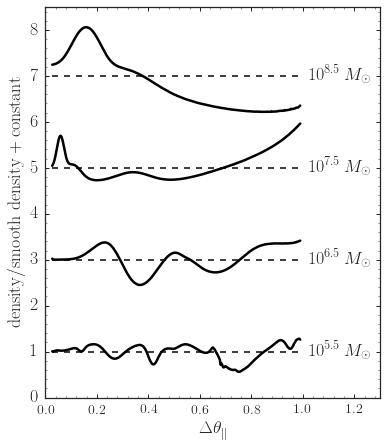

In [80]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=18.)
figsize(6,7)
overplot= False
for ii in range(nexample):
    bovy_plot.bovy_plot(apars,dens_example[ii]/dens_unp+2.*ii,lw=2.5,
                        color='k',
                        xrange=[0.,1.3],
                        yrange=[0.,2.*nexample+0.5],
                        xlabel=r'$\Delta \theta_\parallel$',
                        ylabel=r'$\mathrm{density}/\mathrm{smooth\ density}+\mathrm{constant}$',
                        overplot=overplot)
    plot(apars,apars*0.+1.+2.*ii,lw=1.5,color='k',ls='--',zorder=0)
    bovy_plot.bovy_text(1.025,1.+2.*ii,r'$10^{%.1f}\,M_\odot$' % masses[ii],verticalalignment='center',size=18.)
    overplot=True
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats',
                                          'gd1like_densexample_singlemasses.pdf'))

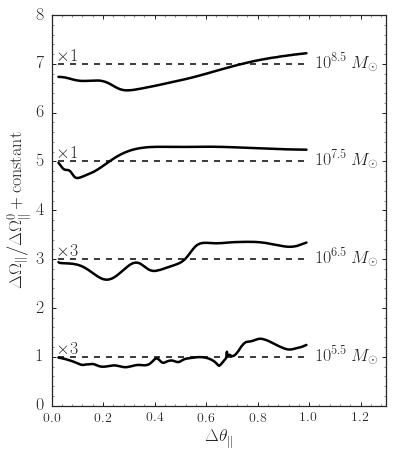

In [81]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=18.)
figsize(6,7)
overplot= False
mult= [3.,3.,1.,1.]
for ii in range(nexample):
    bovy_plot.bovy_plot(apars,mult[ii]*(omega_example[ii]/omega_unp-1.)+1.+2.*ii,
                        lw=2.5,
                        color='k',
                        xrange=[0.,1.3],
                        yrange=[0.,2.*nexample],
                        xlabel=r'$\Delta \theta_\parallel$',
                        ylabel=r'$\Delta \Omega_\parallel\big/\Delta \Omega_\parallel^0+\mathrm{constant}$',
                        overplot=overplot)
    plot(apars,apars*0.+1.+2.*ii,lw=1.5,color='k',ls='--',zorder=0)
    bovy_plot.bovy_text(1.025,1.+2.*ii,r'$10^{%.1f}\,M_\odot$' % masses[ii],verticalalignment='center',size=18.)
    bovy_plot.bovy_text(0.025,1.+2.*ii+0.1,r'$\times%i$' % mult[ii],size=18.)
    overplot= True
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats',
                                          'gd1like_omegaexample_singlemasses.pdf'))

### Full mass range

In [82]:
apars= apars[::30]
dens_unp= dens_unp[::30]
omega_unp= omega_unp[::30]

In [88]:
# Sampling functions
massrange=[5.,9.]
plummer= False
Xrs= 5.
nsubhalo= simulate_streampepper.nsubhalo
rs= simulate_streampepper.rs
dNencdm= simulate_streampepper.dNencdm
sample_GM= lambda: (10.**((-0.5)*massrange[0])\
                                    +(10.**((-0.5)*massrange[1])\
                                          -10.**((-0.5)*massrange[0]))\
                                    *numpy.random.uniform())**(1./(-0.5))\
                                    /bovy_conversion.mass_in_msol(V0,R0)
rate_range= numpy.arange(massrange[0]+0.5,massrange[1]+0.5,1)
rate= numpy.sum([dNencdm(sdf_pepper,10.**r,Xrs=Xrs,
                                plummer=plummer)
                        for r in rate_range])
sample_rs= lambda x: rs(x*bovy_conversion.mass_in_1010msol(V0,R0)*10.**10.,
                            plummer=plummer)

In [89]:
dens_example= []
omega_example= []
# Perform some simulations
numpy.random.seed(3)
nexample= 4
for ii in range(nexample):
    sdf_pepper.simulate(rate=rate,sample_GM=sample_GM,sample_rs=sample_rs,Xrs=Xrs)
    densOmega= numpy.array([sdf_pepper._densityAndOmega_par_approx(a) for a in apars]).T
    dens_example.append(densOmega[0])
    omega_example.append(densOmega[1])

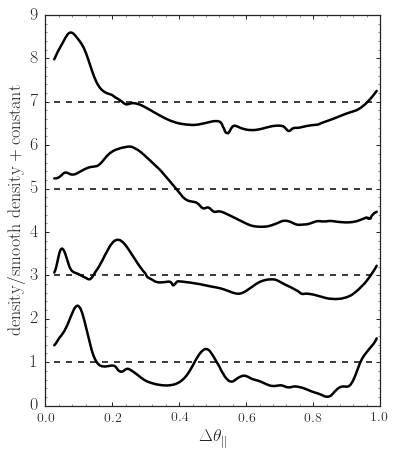

In [98]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=18.)
figsize(6,7)
overplot= False
for ii in range(nexample):
    bovy_plot.bovy_plot(apars,dens_example[ii]/dens_unp+2.*ii,lw=2.5,
                        color='k',
                        xrange=[0.,1.],
                        yrange=[0.,2.*nexample+1.],
                        xlabel=r'$\Delta \theta_\parallel$',
                        ylabel=r'$\mathrm{density}/\mathrm{smooth\ density}+\mathrm{constant}$',
                        overplot=overplot)
    plot(apars,apars*0.+1.+2.*ii,lw=1.5,color='k',ls='--',zorder=0)
    overplot=True
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_densexample.pdf'))

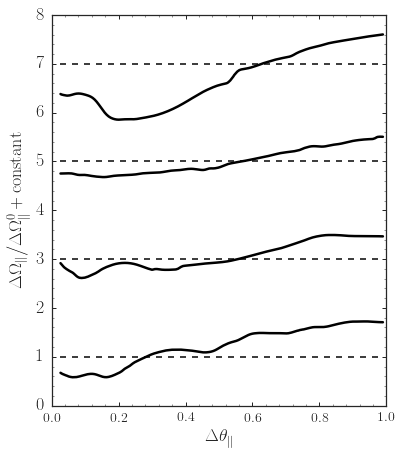

In [99]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=18.)
figsize(6,7)
overplot= False
for ii in range(nexample):
    bovy_plot.bovy_plot(apars,omega_example[ii]/omega_unp+2.*ii,lw=2.5,
                        color='k',
                        xrange=[0.,1.],
                        yrange=[0.,2.*nexample],
                        xlabel=r'$\Delta \theta_\parallel$',
                        ylabel=r'$\Delta \Omega_\parallel\big/\Delta \Omega_\parallel^0+\mathrm{constant}$',
                        overplot=overplot)
    plot(apars,apars*0.+1.+2.*ii,lw=1.5,color='k',ls='--',zorder=0)
    overplot= True
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_omegaexample.pdf'))